In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
%load_ext rich
%load_ext autoreload
%autoreload 1

---

In [3]:
import logging
from mbrl.environments.grid import Grid
%aimport mbrl.environments.grid
from mbrl.environments.self import Self
%aimport mbrl.environments.self
from mbrl.environments.imagelib import Im
%aimport mbrl.environments.imagelib
from mbrl.environments.tangram.polygon import Polygon, Triangle, Quadrilateral
%aimport mbrl.environments.tangram.polygon
from mbrl.environments.tangram.polygonlist import PolygonList
%aimport mbrl.environments.tangram.polygonlist
from mbrl.environments.tangram.tangram import Tangram
%aimport mbrl.environments.tangram.tangram
from mbrl.environments.tangram_env import TangramEnv
%aimport mbrl.environments.tangram_env
from mbrl.environments.tangram_rollout import rollout
%aimport mbrl.environments.tangram_rollout

logging.basicConfig(level=logging.DEBUG)
plt.set_loglevel("error")
logging.getLogger('asyncio').setLevel(logging.ERROR)
logging.getLogger('mbrl.environments.imagelib').setLevel(logging.INFO)

---

In [4]:
HOUSE = np.array([[0.505, 0.49333333], [0.63, 0.36833333], [0.38, 0.36833333], [0.4625, 0.62083333], [0.5875, 0.49583333], [0.3375, 0.49583333], [0.63166667, 0.49416667], [0.63166667, 0.36916667], [0.50666667, 0.49416667], [0.441, 0.43133333], [0.3785, 0.49383333], [0.5035, 0.49383333], [0.44016667, 0.4305], [0.37766667, 0.368], [0.37766667, 0.493], [0.50030583, 0.58530583], [0.50030583, 0.67369417], [0.58869417, 0.67369417], [0.58869417, 0.58530583], [0.5885, 0.58469417], [0.50011165, 0.58469417], [0.5885, 0.49630583], [0.67688835, 0.49630583]])
TREE = np.array([[0.50392557, 0.50607443], [0.32714887, 0.50607443], [0.50392557, 0.68285113], [0.50607443, 0.50607443], [0.50607443, 0.68285113], [0.68285113, 0.50607443], [0.41, 0.49392557], [0.49838835, 0.40553722], [0.32161165, 0.40553722], [0.50553722, 0.40753722], [0.50553722, 0.49592557], [0.59392557, 0.40753722], [0.50446278, 0.49446278], [0.50446278, 0.40607443], [0.41607443, 0.49446278], [0.45580583, 0.31580583], [0.45580583, 0.40419417], [0.54419417, 0.40419417], [0.54419417, 0.31580583], [0.6, 0.49419417], [0.51161165, 0.49419417], [0.6, 0.40580583], [0.68838835, 0.40580583]])

> **TREE**

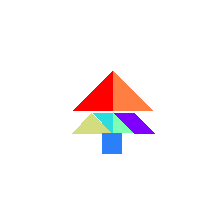

In [5]:
tangram = Tangram(x_size=1, x_step=3, max_dist=-1)  # control_boundaries=[[0, 0], [0.5, 0.5]]
# triangle-large-red triangle-large-orange triangle-medium-yellow triangle-small-lightgreen triangle-small-darkgreen square-small-blue parallelogram-small-purple
tangram.positions = [(0.445, 0.565), (0.565, 0.565), (0.41, 0.435), (0.535, 0.437), (0.475, 0.465), (0.5, 0.36), (0.6, 0.45)]
tangram.angles = [0.5, 0., -0.75, 0., 1, 0., 0.75]
tangram.flips = [0, 0, 0, 0, 0, 0, 1]
tangram.mask()
tangram.checkpoint()
tangram.reorder()
# tangram.reset()
tangram

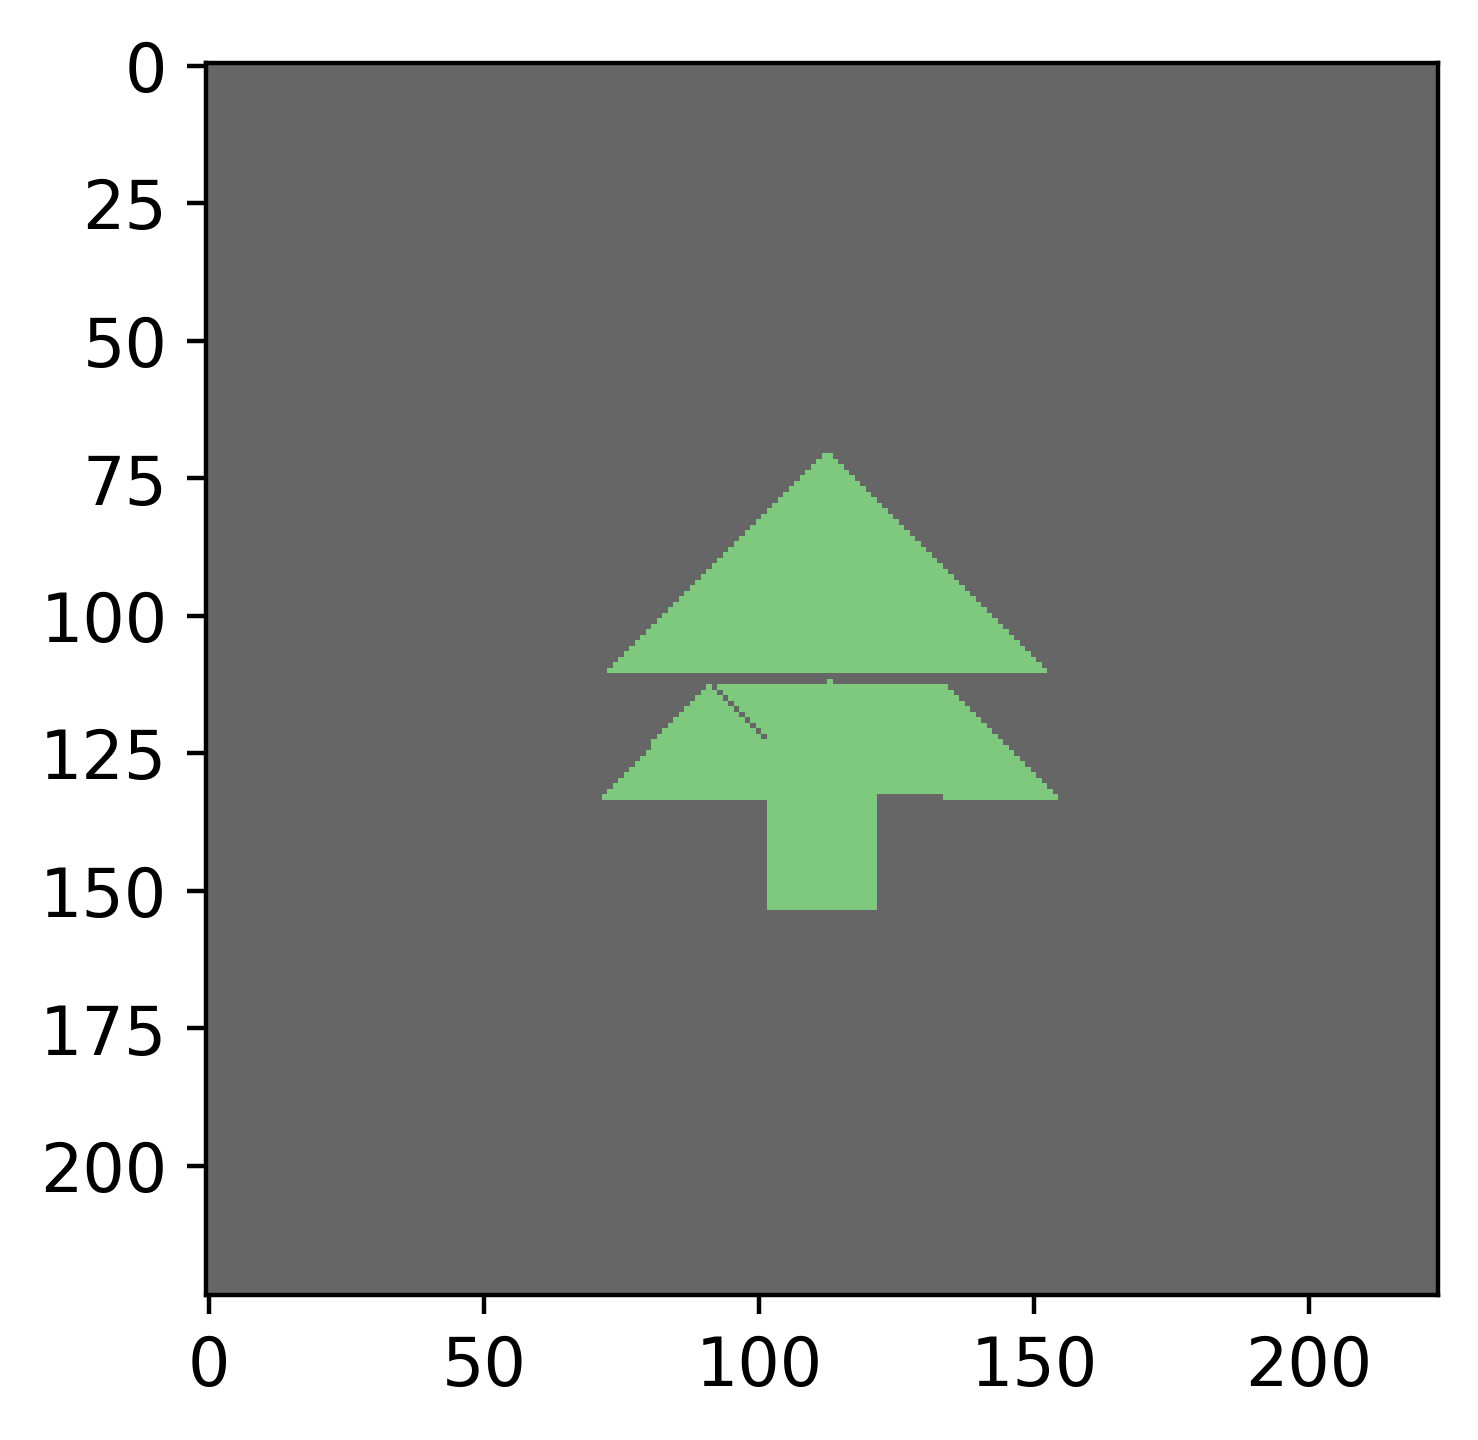

In [9]:
plt.imshow(tangram.render_image(format='array', invert=False, crop=False, color=False, figsize=[4, 4], dpi=56, fast=True, lineType=8))
# plt.savefig("registered_image.png")

---

> **HOUSE**

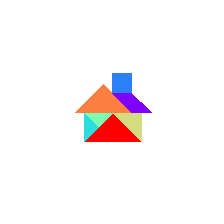

In [11]:
tangram = Tangram(x_size=28, max_dist=3, control_boundaries=[[0, 0], [16, 16]])
# triangle-large-red triangle-large-orange triangle-medium-yellow triangle-small-lightgreen triangle-small-darkgreen square-small-blue parallelogram-small-purple
tangram.positions = [(0.505, 0.41), (0.4625, 0.5375), (0.59, 0.4525), (0.441, 0.473), (0.3985, 0.4305), (0.5445, 0.6295), (0.5885, 0.5405)]
tangram.angles = [-0.75, -0.75, -1., 0.25, 0.75, 0, 0.75]
tangram.flips = [0, 0, 0, 0, 0, 0, 1]
tangram.mask()
tangram.checkpoint()
tangram.reorder()
# tangram.reset()
tangram

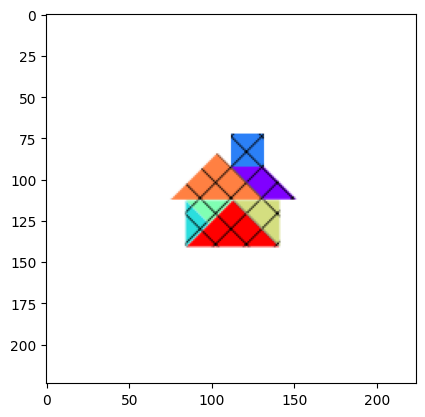

In [9]:
plt.imshow(tangram.render(hatch='x'))

---

In [10]:
assert False

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 assert False                                                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

---

### Regularity Bit

In [ ]:
def compress(values):
    compressed_keys = []
    compressed_values = []

    for v in values:
        if v in compressed_keys:
            compressed_values[compressed_keys.index(v)] += 1
        else:
            compressed_keys.append(v)
            compressed_values.append(1)

    print(compressed_keys, compressed_values)
    return entropy(np.asarray(compressed_values))

def entropy(xs):
    xs = xs / np.sum(xs)
    return -np.sum(xs * np.log(xs))

In [ ]:
from collections import Counter
def regularity(objects, metric=lambda a, b: a - b, *, cost=True, shift=False, normalize=False, precision=1., granularity=1., bidirectional=False):
    multiset = Counter(map(tuple, (np.floor(((lambda x: x) if bidirectional else np.abs)(metric(np.expand_dims(objects, 1), objects).reshape(-1, 2)) * precision / granularity) * granularity).astype(int)))
    print(list(multiset.keys()), list(multiset.values()))
    distribution = np.asarray(list(multiset.values()))
    n = len(objects)
    assert sum(distribution) == (nt := n * n), (sum(distribution), nt)
    r = (distribution @ np.log(distribution) / nt - (0 if shift else np.log(nt))) * (-1 if cost else 1)
    return (r / np.log(nt), 1) if normalize else (r, np.log(nt))  # (regularity, max regularity)


In [ ]:
objects = np.array([[0.5119048 , 0.21428572],
              [0.38690472, 0.08928569],
              [0.38690475, 0.33928573],
              [0.4517827 , 0.76250297],
              [0.275006  , 0.76250297],
              [0.4517827 , 0.9392797 ],
              [0.10714287, 0.27321127],
              [0.1955312 , 0.18482293],
              [0.01875451, 0.18482293],
              [0.64910865, 0.6133944 ],
              [0.64910865, 0.7017827 ],
              [0.737497  , 0.6133944 ],
              [0.6366056 , 0.77946275],
              [0.6366056 , 0.69107443],
              [0.5482173 , 0.77946275],
              [0.38437727, 0.42009154],
              [0.38437727, 0.5084799 ],
              [0.4727656 , 0.5084799 ],
              [0.4727656 , 0.42009154],
              [0.6       , 0.49419415],
              [0.5116117 , 0.49419415],
              [0.6       , 0.40580583],
              [0.68838835, 0.40580583]], dtype=float)


In [ ]:
print(regularity(objects := [[0,1], [0,3], [0,2]], cost=True, shift=False, normalize=False)[0], '\n')
print(compress(np.abs(np.expand_dims(objects, axis=1) - objects).reshape(-1, 2).tolist()))

[(0, 0), (0, 2), (0, 1)] [3, 2, 4]
1.0608569471580211 

[[0, 0], [0, 2], [0, 1]] [3, 2, 4]
1.0608569471580214


In [ ]:
entropy([3,2,1])

1.0114042647073516

---

### Older Bit

In [ ]:
rollout(
    env=TangramEnv(x_size=28, max_dist=1, x_step=3, control_boundaries=[[0, 0], [16, 16]]),
    categories=["house", "bird", "fish", "tree", "cat", "dog", "horse", "rabbit", "goat", "shirt", "chair", "boat"],
    label_prefix="a ",
    label_suffix="",
    overwrite=True,
    overwrite_plot=True,
    overwrite_animation=True,
    device="cpu",
    frames=200,
    target_path="tangram_results.ignore/rollouts/house",
    save_path="results/tangram_videos/rollouts/house",
    initial=HOUSE,
    start=tangram.vertices
)

In [ ]:
##> HOUSE

# tangram[0].position = (0.441, 0.47)
# tangram[0].angle = -0.75

# tangram[1].position = (0.4, 0.6)
# tangram[1].angle = -0.75

# tangram[2].position = (0.525, 0.515)
# tangram[2].angle = -1.

# tangram[3].position = (0.379, 0.536)
# tangram[3].angle = 0.25

# tangram[4].position = (0.335, 0.493)
# tangram[4].angle = 0.75

# tangram[5].position = (0.48, 0.695)
# tangram[5].angle = 0

# tangram[6].position = (0.525, 0.605)
# tangram[6].angle = 0.75
# tangram[6].flipped = 1

# tangram.positions = [(0.505, 0.41), (0.4625, 0.5375), (0.59, 0.4525), (0.441, 0.473), (0.3985, 0.4305), (0.5445, 0.6295), (0.5885, 0.5405)]
# tangram.angles = [-0.75, -0.75, -1., 0.25, 0.75, 0, 0.75]
# tangram.flips = [0, 0, 0, 0, 0, 0, 1]

# plt.figure(figsize=(15, 15))
# plt.imshow(tangram.render_image(dpi=300))
# plt.title(tangram._validate())
# plt.show()

---

In [ ]:
# tangram = Tangram(staging_boundaries=[[0.2, 0.2], [0.8, 0.8]], staging_criteria="center")
# display(tangram.render_image(highlight_active=True))
# tangram.render_image(crop=False, highlight_active=True)

In [ ]:
# tangram.step([0.9, 0, 0])
# tangram

In [ ]:
# tangram.transform(6, *[0, 0, 0, 1])
# tangram

---

In [ ]:
assert False

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 assert False                                                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

In [ ]:
def discretize(action, step=1, size=1.):
    return ((action + 1) * (step + 0.5) // 1 - step) / size


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from itertools import chain

def collides(p, q):
    # edges = lambda vertices: (np.roll(vertices, -1, axis=0) - vertices)
    # for edge in chain(edges(p), edges(q)):
    #     r = p @ edge
    #     s = q @ edge
    #     if np.max(r) <= np.min(s) or np.max(s) <= np.min(r):
    #         return False
    # return True

    edges = lambda vertices: (np.roll(vertices, -1, axis=0) - vertices)
    normals = [[0, -1], [1, 0]] @ np.r_[edges(p), edges(q)].T
    r = p @ normals
    s = q @ normals
    # return np.all((np.max(r, axis=0) > np.min(s, axis=0)) & (np.max(s, axis=0) > np.min(r, axis=0)))
    return all((a > b) and (c > d) for a, b, c, d in zip(np.max(r, axis=0), np.min(s, axis=0), np.max(s, axis=0), np.min(r, axis=0)))

In [ ]:
p = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
q = np.array([[0, 0], [1, 0], [1, 1]]) + 1.01

In [ ]:
Polygon.collides(p, q)

False

In [ ]:
tangram = Tangram()

In [ ]:
polygon = Triangle(name='triangle-large-1', scale=(0.15,), color=(1., 0., 0., 1.))                                         # 2 large right triangles

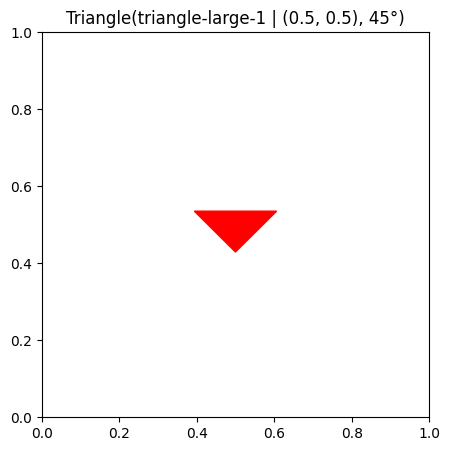

In [ ]:
polygon.position = (0.5, 0.5)
polygon.rotate(0.25)
polygon.show();

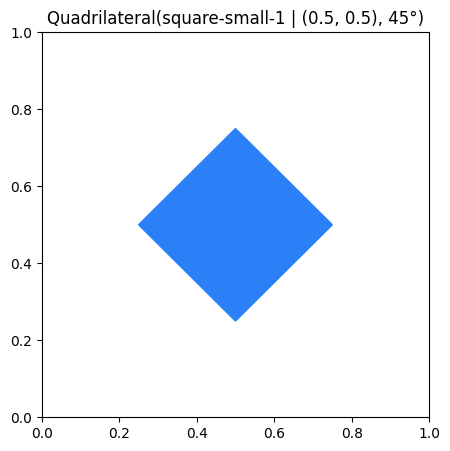

0.25 0.25


In [ ]:
square = Quadrilateral(name='square-small-1', scale=(0.5/np.sqrt(2),), color=(0.17, 0.5, 0.97, 1.))
square.rotate(0.25)
square.translate(0.5, 0.5)
square.show()
print(square._angle, square.angle)

In [ ]:
tl = PolygonList([
    Quadrilateral(name='square-small-1', scale=(0.5,), color=(0.17, 0.5, 0.97, 1.)),                                     # 1 small square
    Quadrilateral(name='parallelogram-small-1', scale=(2**-0.5, 0.5), shear=(0, 0.25), color=(0.5, 0., 1., 1.)),         # 1 small parallelogram
])
tl.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│   2 │   Quadrilateral(name='square-small-1', scale=(0.5,), color=(0.17, 0.5, 0.97, 1.)),         │
│   3 │   Quadrilateral(name='parallelogram-small-1', scale=(2**-0.5, 0.5), shear=(0, 0.25), c     │
│   4 ])                                                                                           │
│ ❱ 5 tl.show()                                                                                    │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'list' object is not callable

---

Polygon4((0.1, 0.1) ...)
Polygon4((0.1, 0.1) ...)


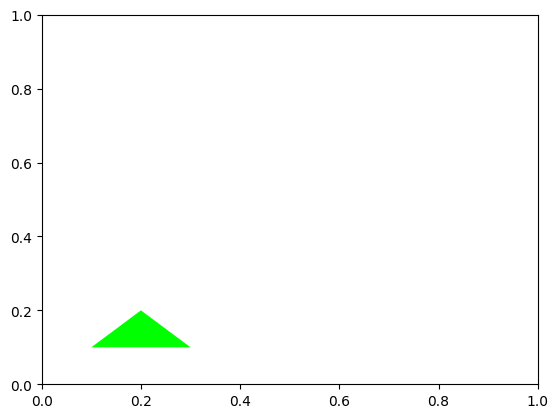

In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as Po, PathPatch
from matplotlib.path import Path as Pa

np.random.seed(6)

fig, ax = plt.subplots()

polygon_1 = Po(Pa([[0.1,0.1],[0.2,0.2],[0.3,0.1]]).to_polygons(closed_only=True)[0])
print(polygon_1)
polygon_2 = Po([[0.1,0.1],[0.2,0.2],[0.3,0.1]])
print(polygon_2)

p = PatchCollection([polygon_2])
p.set_facecolor([0,1,0])
ax.add_collection(p)

# p = polygon_2
# p.set_facecolor([0,1,0])
# ax.add_patch(p)

plt.show()


---

In [ ]:
from functools import wraps

In [ ]:
class Self:
    """Decorator to allow passing an object itself to methods that actually take some attribute of that object."""
    def __init__(self, attr: str, cls: str = None):
        print("INIT")
        self.attr = attr
        self.cls = (cls,) if isinstance(cls, str) else cls

    def _filter(self, cls: type):
        return cls.__name__ in self.cls

    def __call__(self, func: type):
        print("CALL")
        @wraps(func)
        def wrapper(*args, **kwargs):
            print("FINAL")
            return func(*[getattr(arg, self.attr) if self._filter(arg.__class__) else arg for arg in args], **kwargs)
        return wrapper

class SelfMixin(Self):
    """Mixin class that provides a class method as decorator to allow passing the object itself to the wrapped functions that actually take some attribute of that object."""
    def __init__(self, *args, **kwargs):
        print("Mixin")
        super().__init__(*args, **kwargs)

    @classmethod
    def _filter(self, cls: type):
        return issubclass(cls, self)

In [ ]:
class A:
    def __init__(self, a: int = 0):
        self.a = a

    @Self("a", 'A')
    def get_b(a):
        return a + 1
    b = property(get_b)

INIT
CALL


In [ ]:
a = A(1)
A.b()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 a = A(1)                                                                                     │
│ ❱ 2 A.b()                                                                                        │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'property' object is not callable

In [ ]:
class A:
    def __init__(self, *args, **kwargs):
        print('A', args, kwargs)

class B(A):
    def __init__(self, *args, **kwargs):
        print('B', args, kwargs)
        super().__init__(*args, **kwargs)

class C:
    def __init__(self, *args, **kwargs):
        print('C', args, kwargs)

class D(SelfMixin, B, C):
    def __init__(self, *args, **kwargs):
        print('D', args, kwargs)
        print(super(B).__init__(self, *args))
        # super(C, self).__init__(*args, **kwargs)

d = D(1, b=2)

D (1,) {'b': 2}


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17 │   │   print(super(B).__init__(self, *args))                                               │
│   18 │   │   # super(C, self).__init__(*args, **kwargs)                                          │
│   19                                                                                             │
│ ❱ 20 d = D(1, b=2)                                                                               │
│   21                                                                                             │
│                                                                                                  │
│ in __init__:17                                                                                   │
│                                                                                                  │
│   14 class D(SelfMixin, B, C):                                                                   │
│   15 │   def __init__(self, *args, **kwargs):                                                    │
│   16 │   │   print('D', args, kwargs)                                                            │
│ ❱ 17 │   │   print(super(B).__init__(self, *args))                                               │
│   18 │   │   # super(C, self).__init__(*args, **kwargs)                                          │
│   19                                                                                             │
│   20 d = D(1, b=2)                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: super() argument 1 must be type, not D

In [ ]:
class A:
    def __init__(self):
        self.call('A', self.__class__.__name__)
        super().__init__()

    @classmethod
    def call(cls, supercls, calling_cls):
        print(supercls, cls.__name__, calling_cls)

class B(A):
    def __init__(self):
        self.call('B', self.__class__.__name__)
        super().__init__()

class C:
    def __init__(self):
        self.call('C', self.__class__.__name__)
        super().__init__()

class D(B, C):
    def __init__(self):
        self.call('D', self.__class__.__name__)
        super().__init__()

# B()
# C()
D()

D D D
B D D
A D D
C D D


In [ ]:
class Self:
    """Decorator to allow passing an object itself to methods that actually take some attribute of that object."""
    def __init__(self, attr: str, cls: str = None):
        self.attr = attr
        self.cls = cls

    def _filter(self, cls: type):
        return cls.__name__ == self.cls

    def __call__(self, func: type):
        @wraps(func)
        def wrapper(*args, **kwargs):
            return func(*[getattr(arg, self.attr) if self._filter(arg.__class__) else arg for arg in args], **kwargs)
        return wrapper

class SelfMixin(Self):
    """Mixin class that provides a class method as decorator to allow passing the object itself to the wrapped functions that actually take some attribute of that object."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @classmethod
    def _filter(self, cls: type):
        return issubclass(cls, self)

In [ ]:
class F:
    def __init__(self, a=1):
        super().__init__()
        self.a = a

    @classmethod
    @Self('F', 'a')
    def f(a):
        print('FF', a)

    @Self('F', 'a')
    def g(a):
        print('FG', a)


class G(SelfMixin):
    def __init__(self, a=1):
        super().__init__()
        self.a = a

    @classmethod
    @Self('G', 'a')
    def f(a):
        print('GF', a)

    @Self('G', 'a')
    def g(a):
        print('GG', a)

In [ ]:
F(2).f()
F(2).g()
G(2).f()
G(2).g()

FF <class '__main__.F'>
FG <__main__.F object at 0x7f6e9f191b20>


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 F(2).f()                                                                                     │
│   2 F(2).g()                                                                                     │
│ ❱ 3 G(2).f()                                                                                     │
│   4 G(2).g()                                                                                     │
│   5                                                                                              │
│                                                                                                  │
│ in __init__:18                                                                                   │
│                                                                                                  │
│   15                                                                                             │
│   16 class G(SelfMixin):                                                                         │
│   17 │   def __init__(self, a=1):                                                                │
│ ❱ 18 │   │   super().__init__()                                                                  │
│   19 │   │   self.a = a                                                                          │
│   20 │                                                                                           │
│   21 │   @classmethod                                                                            │
│                                                                                                  │
│ in __init__:19                                                                                   │
│                                                                                                  │
│   16 class SelfMixin(Self):                                                                      │
│   17 │   """Mixin class that provides a class method as decorator to allow passing the object    │
│   18 │   def __init__(self, *args, **kwargs):                                                    │
│ ❱ 19 │   │   super().__init__(*args, **kwargs)                                                   │
│   20 │                                                                                           │
│   21 │   @classmethod                                                                            │
│   22 │   def _filter(self, cls: type):                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: __init__() missing 1 required positional argument: 'attr'

In [ ]:
class Self:
    """Decorator to allow passing an object itself to class methods that actually take some attribute of that object."""
    def __init__(self, attr, cls=None):
        self.attr = attr
        self.cls = cls

    def __call__(self, func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            return func(*[getattr(arg, self.attr) if isinstance(arg, self.cls) else arg for arg in args], **kwargs)
        return wrapper

In [ ]:
class C:
    def __init__(self, a=1):
        self.a = a

    @Self('a', 'C')
    def f(a):
        print(a)

In [ ]:
c = C(1)

In [ ]:
c.f()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 c.f()                                                                                        │
│   2                                                                                              │
│                                                                                                  │
│ in wrapper:10                                                                                    │
│                                                                                                  │
│    7 │   def __call__(self, func):                                                               │
│    8 │   │   @wraps(func)                                                                        │
│    9 │   │   def wrapper(*args, **kwargs):                                                       │
│ ❱ 10 │   │   │   return func(*[getattr(arg, self.attr) if isinstance(arg, self.cls) else arg     │
│   11 │   │   return wrapper                                                                      │
│   12                                                                                             │
│                                                                                                  │
│ in <listcomp>:10                                                                                 │
│                                                                                                  │
│    7 │   def __call__(self, func):                                                               │
│    8 │   │   @wraps(func)                                                                        │
│    9 │   │   def wrapper(*args, **kwargs):                                                       │
│ ❱ 10 │   │   │   return func(*[getattr(arg, self.attr) if isinstance(arg, self.cls) else arg     │
│   11 │   │   return wrapper                                                                      │
│   12                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: isinstance() arg 2 must be a type or tuple of types

In [ ]:
from __future__ import annotations
from functools import wraps

In [ ]:
class SelfMixin:
    """Mixin class that provides a class method as decorator to allow passing the object itself to the wrapped functions that actually take some attribute of that object."""
    def __init__(self, attr, *args, **kwargs):
        self.attr = attr
        super().__init__(*args, **kwargs)

    def __call__(self, func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            print('>>', args[0].__class__, self.__class__, isinstance(args[0], self.__class__))
            return func(*[getattr(arg, self.attr) if isinstance(arg, self.__class__) else arg for arg in args], **kwargs)
        return wrapper

In [ ]:
class D(SelfMixin):
    def __init__(self, a=1):
        self.a = a

    @SelfMixin('a')
    def f(a):
        print(a)

In [ ]:
d = D(1)

In [ ]:
D.f(1)

>> <class 'int'> <class '__main__.SelfMixin'> False
1


In [ ]:
class Self:
    """Decorator to allow passing an object itself to class methods that actually take some attribute of that object."""
    def __init__(self, cls, attr):
        self.cls = cls
        self.attr = attr

    def __call__(self, func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            return func(*[getattr(arg, self.attr) if arg.__class__.__name__ == self.cls else arg for arg in args], **kwargs)
        return wrapper

In [ ]:
class E:
    def __init__(self, a=1):
        self.a = a

    @Self('E', 'a')
    def f(a):
        print(a)

In [ ]:
e = E(1)

In [ ]:
E.f(1)

1
